In [1]:
import sys
sys.path.append('..')

from common.utility import show_implementation
from module.utility import show_images
import numpy as np
from PIL import Image

In [2]:
rose_image = Image.open('images/rose.jpg').resize((288, 216))
rose_image_rgb = np.array(rose_image.convert('RGB'))

woman_image = Image.open('images/woman.jpg').resize((288, 216))
woman_image_grey = np.array(woman_image.convert('L'))

# Point Processing

Point processing refers to the application of a certain function for each pixel in the image to obtain a new corresponding pixel in the new image.
Thus, the resultant image is the same size as the original.

## Brightness
To adjust brightness, we simply add or subtract some intensity value from each pixel.

In [3]:
from module.point_process import adjust_brightness
show_implementation(adjust_brightness)

def adjust_brightness(img, amount):
    img = img.astype(np.uint16)
    return np.clip(img + amount, 0, 255)


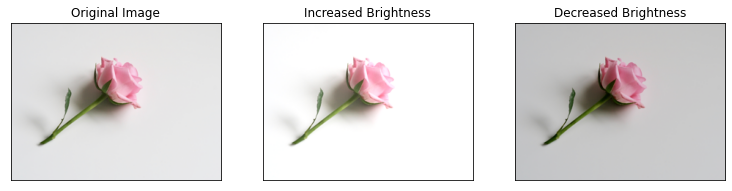

In [4]:
show_images([(rose_image_rgb, 'Original Image'),
            (adjust_brightness(rose_image_rgb, 30), 'Increased Brightness'),
            (adjust_brightness(rose_image_rgb, -30), 'Decreased Brightness')])

Notice that if we adjust the brightness, some values may be clipped to 255 with increasing brightness, or to 0 with decreasing brightness.
Since there is no way of determining what the original value is after clipping occurs, some information of the image is lost.

## Contrast
To adjust contrast, we scale all the pixel values by a factor.
By scaling the pixel values with a factor > 1, the intensity difference between pixels becomes more pronounced, thus increasing contrast.

In [5]:
from module.point_process import adjust_contrast
show_implementation(adjust_contrast)

def adjust_contrast(img, amount):
    img = np.array(img).astype(np.float32)
    return np.clip(img * amount, 0, 255).astype(np.uint16)


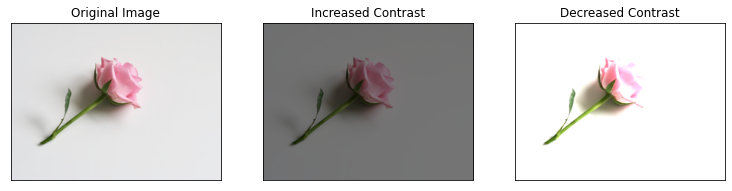

In [6]:
show_images([(rose_image_rgb, 'Original Image'),
            (adjust_contrast(rose_image_rgb, 0.5), 'Increased Contrast'),
            (adjust_contrast(rose_image_rgb, 1.5), 'Decreased Contrast')])

## Gamma Mapping
The point processing need not be linear.
For example, in gamma mapping, we set each pixel to be 
$$
x'_{i,j} = 255 \times \left(\frac{x_{i,j}}{255}\right)^\gamma
$$

In [7]:
from module.point_process import adjust_gamma
show_implementation(adjust_gamma)

def adjust_gamma(img, gamma):
    img = np.array(img).astype(np.float32)
    return np.clip(255 * (img / 255) ** gamma, 0, 255).astype(np.uint16)


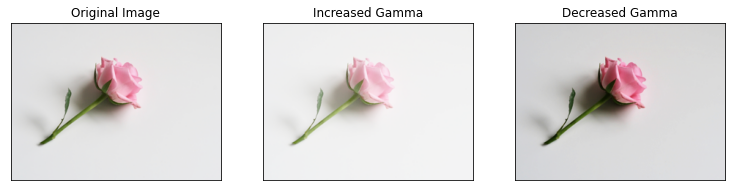

In [8]:
show_images([(rose_image_rgb, 'Original Image'),
            (adjust_gamma(rose_image_rgb, 0.5), 'Increased Gamma'),
            (adjust_gamma(rose_image_rgb, 1.5), 'Decreased Gamma')])

## Normalization
In normalization, also known as whitening, we reduce the spread of intensity values of pixels such that it follows a normal distribution.
Thus, each pixel is adjusted as
$$
x'_{i,j} = \frac{x_{i,j} - \mu}{\sigma}
$$


(We work on greyscale image from now on for ease of explanation.
We can apply the discussion to each of the RGB channels as per previously to achieve similar effect on coloured images)

We also use a new image because the rose image has "too much white" and creates bad results when normalized.

In [9]:
from module.point_process import whiten
show_implementation(whiten)

def whiten(img):
    mu = np.array(img).mean()
    sigma = np.array(img).std()
    return np.clip((img-mu)/sigma * 255, 0, 255)


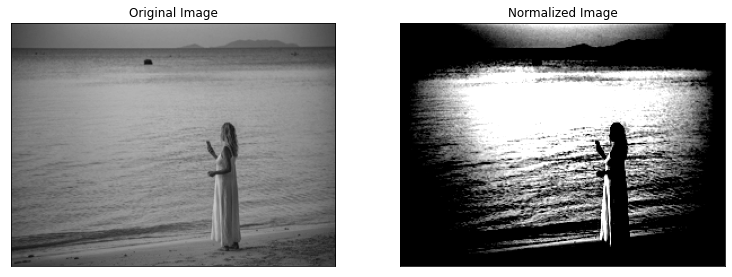

In [10]:
show_images([(woman_image_grey, 'Original Image'),
            (whiten(woman_image_grey), 'Normalized Image')])

Image by <a href="https://pixabay.com/users/peggy_marco-1553824/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=4935894">Peggy und Marco Lachmann-Anke</a> from <a href="https://pixabay.com/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=4935894">Pixabay</a>

This process removes additive brightness and contrast, which allows us to standardise those parameters for images taken in different environments.


## Image Histogram
Suppose we consider the distribution of intensity across the image.
Notice that this information does not depend on the location of the pixel, as we can see below.
Each $y$ value tells us how many pixels have intensity $\leq x$.

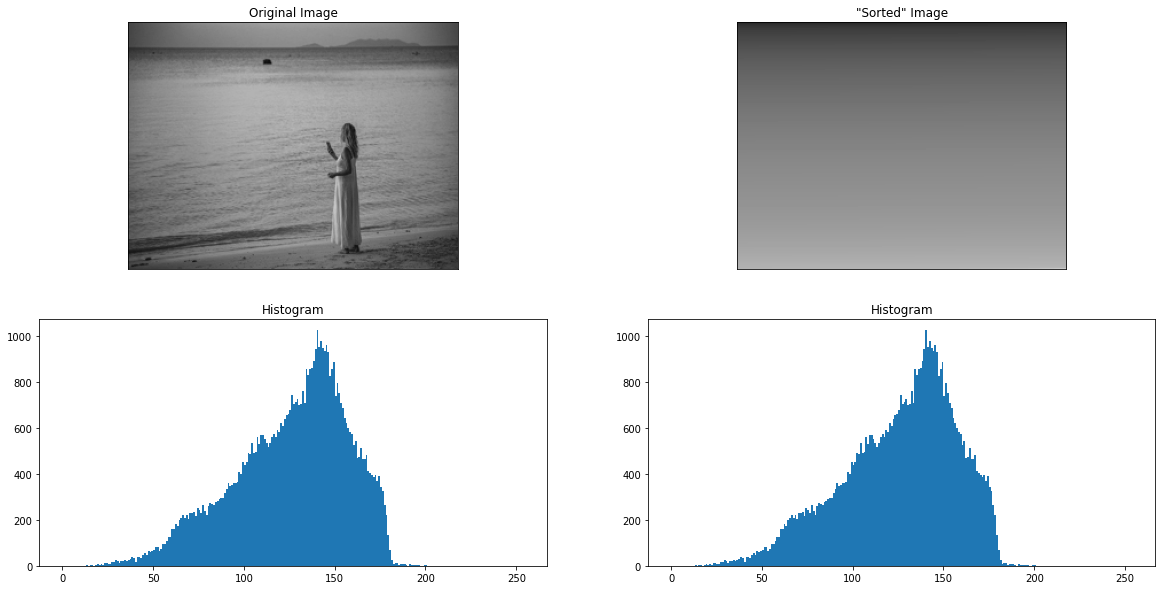

In [11]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(20,10))
ax11 = f.add_subplot(221)
ax12 = f.add_subplot(222)
ax21 = f.add_subplot(223)
ax22 = f.add_subplot(224)

ax11.title.set_text('Original Image')
ax11.imshow(woman_image_grey, cmap='gray', vmin=0, vmax=255)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)

ax21.title.set_text('Histogram')
ax21.hist(woman_image_grey.ravel(), bins=range(255))

sorted_image = np.sort(woman_image_grey.ravel()).reshape(woman_image_grey.shape)
ax12.title.set_text('"Sorted" Image')
ax12.imshow(sorted_image, cmap='gray', vmin=0, vmax=255)
ax12.xaxis.set_visible(False)
ax12.yaxis.set_visible(False)

ax22.title.set_text('Histogram')
ax22.hist(sorted_image.ravel(), bins=range(255));

### Histogram Stretching
We can remap each pixel to a new value such that the histogram is stretched to fill the full range of 0-255.

In [12]:
from module.point_process import hist_stretch
show_implementation(hist_stretch)

def hist_stretch(img):
    lo = img.min()
    hi = img.max()
    img = img.astype(np.float32)
    return np.clip((img - lo) * 255/(hi-lo), 0, 255)


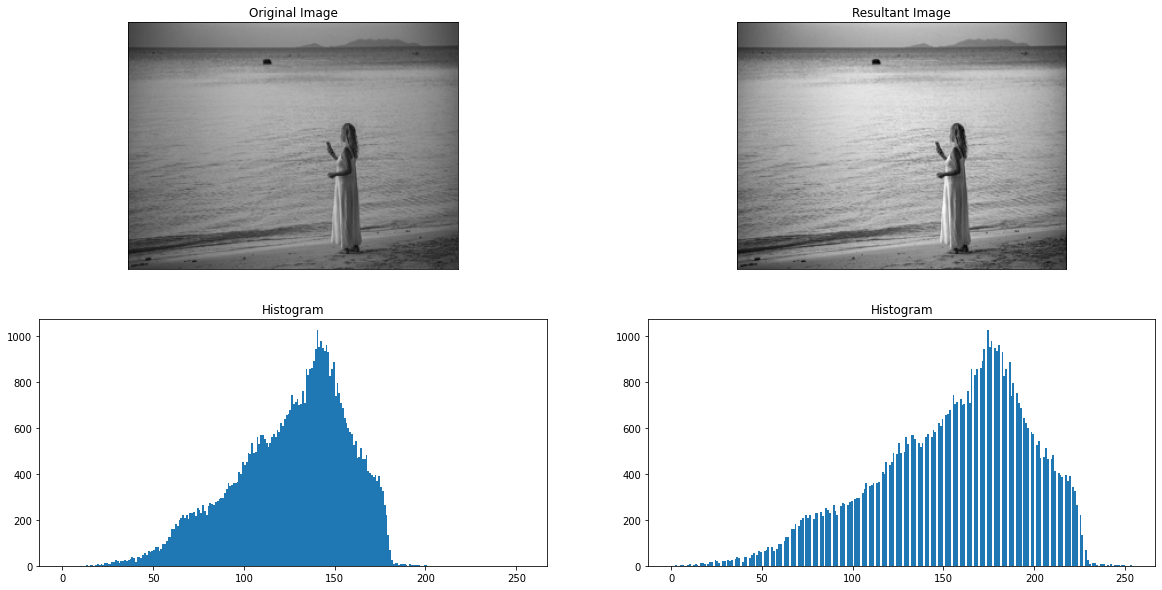

In [13]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(20,10))
ax11 = f.add_subplot(221)
ax12 = f.add_subplot(222)
ax21 = f.add_subplot(223)
ax22 = f.add_subplot(224)

ax11.title.set_text('Original Image')
ax11.imshow(woman_image_grey, cmap='gray', vmin=0, vmax=255)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)

ax21.title.set_text('Histogram')
ax21.hist(woman_image_grey.ravel(), bins=range(255))

stretched_image = hist_stretch(woman_image_grey)
ax12.title.set_text('Resultant Image')
ax12.imshow(stretched_image, cmap='gray', vmin=0, vmax=255)
ax12.xaxis.set_visible(False)
ax12.yaxis.set_visible(False)

ax22.title.set_text('Histogram')
ax22.hist(stretched_image.ravel(), bins=range(255));

This stretching allows the image to use the full range of intensity values possible, thus improving the contrast.

### Histogram Equalization


Suppose we were to plot the cumulative distribution of the pixel values.
The cumulative distribution is derived from the previous histogram, where each $y$ value tells us how many pixels have intensity values $\leq x$.
Notice that the distribution curve is (usually) not linear.

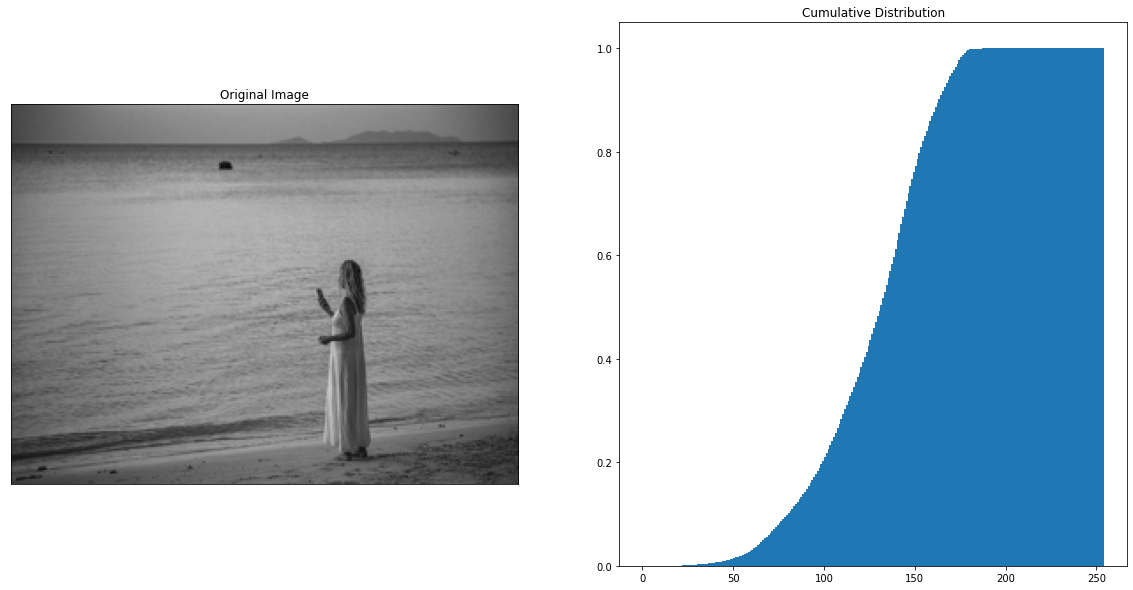

In [14]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(20,10))
ax11 = f.add_subplot(121)
ax12 = f.add_subplot(122)

ax11.title.set_text('Original Image')
ax11.imshow(woman_image_grey, cmap='gray', vmin=0, vmax=255)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)

ax12.title.set_text('Cumulative Distribution')
ax12.hist(woman_image_grey.ravel(), bins=range(255), density=True, cumulative=True);

In [15]:
from module.point_process import hist_eq
show_implementation(hist_eq)

def hist_eq(img):
    freqs, bins = np.histogram(img.ravel(), bins=range(257),range=(0, 256), density=True)
    
    intensity_map = {}
    pdf = 0
    for f, b in zip(freqs, bins): 
        pdf += f
        intensity_map[b] = 255 * pdf

    map_pixels = lambda x: round(intensity_map[x])
    map_pixels = np.vectorize(map_pixels)
    return map_pixels(img)


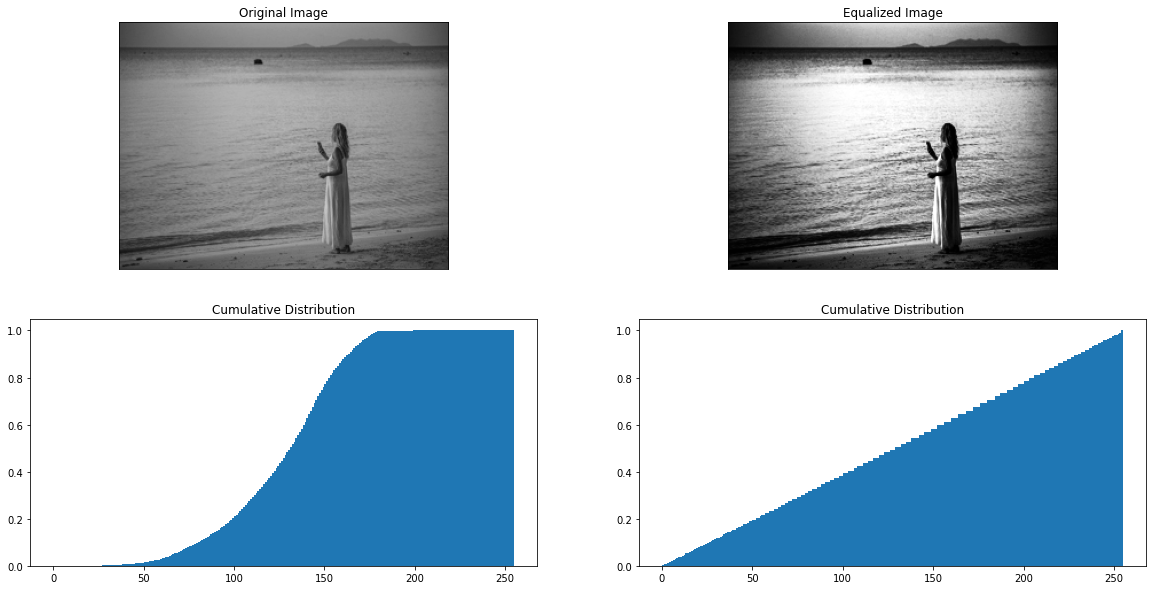

In [16]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(20,10))
ax11 = f.add_subplot(221)
ax12 = f.add_subplot(222)
ax21 = f.add_subplot(223)
ax22 = f.add_subplot(224)

ax11.title.set_text('Original Image')
ax11.imshow(woman_image_grey, cmap='gray', vmin=0, vmax=255)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)

ax21.title.set_text('Cumulative Distribution')
ax21.hist(woman_image_grey.ravel(), bins=range(256), density=True, cumulative=True);

eq_image = hist_eq(woman_image_grey)
ax12.title.set_text('Equalized Image')
ax12.imshow(eq_image, cmap='gray', vmin=0, vmax=255)
ax12.xaxis.set_visible(False)
ax12.yaxis.set_visible(False)

ax22.title.set_text('Cumulative Distribution')
ax22.hist(eq_image.ravel(), bins=range(256), density=True, cumulative=True);

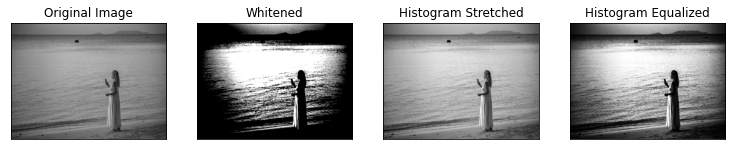

In [17]:
show_images([(woman_image_grey, 'Original Image'),
           (whiten(woman_image_grey), 'Whitened'),
           (hist_stretch(woman_image_grey), 'Histogram Stretched'),
           (hist_eq(woman_image_grey), 'Histogram Equalized')])


As we can see, equalization boosts the contrast much more than histogram stretching, while not being too aggressive like normalization which causes some artifacts to appear.
However, it is to note that equalization is the most expensive operation in the group.